In [20]:
# import necessary libraries
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.sparse.linalg import eigsh
from scipy.signal import find_peaks
from scipy.spatial import Delaunay
from scipy.spatial import distance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import multiprocessing as mp
from sklearn import metrics
import networkx as nx
import numpy as np
import random
import csv
import seaborn

In [2]:
def plot_points(P, labels, plot_tile, s) :
    plt.figure(figsize = (7, 7))
    plt.scatter(P[:,0], P[:,1], c = labels, cmap = 'rainbow_r', s = s)
    plt.gca().set_aspect('equal'), plt.title(plot_tile), plt.xlabel('x(mm)'), plt.ylabel('y(mm)')
    plt.show()

In [3]:
def plot_the_graph(G, P, plot_title, node_size):
    plt.figure(figsize=(7,7))
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    nx.draw(G, P, node_size=[node_size for v in range(P.shape[0])], node_color='lightgreen'
            ,edgelist=edges, edge_color=weights, width=5, edge_cmap=plt.cm.Blues)
    plt.title(plot_title)
    plt.gca().set_aspect('equal')
    plt.show()

In [4]:
def plot_clusters_with_graph(G, P, labels, plot_title, node_size):
    plt.figure(figsize=(7, 7))
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    nodes = [i for i in G.nodes()]
    e = []
    w = []

    for i, edge in enumerate(edges):
        p1 = edge[0]
        p2 = edge[1]
        if labels[p1] == labels[p2] :
            e.append((p1, p2))
            w.append(1000)

    nx.draw(G, P, node_size=[node_size for v in range(P.shape[0])], node_color=labels[nodes], 
            cmap=plt.cm.rainbow_r ,edgelist=e, edge_color=w, width=1)
    plt.title(plot_title)
    plt.show()

In [5]:
def denoise(P, Sigma, sigma_s, noise_thrsh, plot_den_hist) :
    # Inputs : 
    # P_i           : [x, y], the localization centers
    # Sigma_i       : [[sigma_x_i, 0], [0, sigma_y_i]] where sigma_x_i and sigma_y_i are 
    # uncertinties in x and y direction  of the P_i localization respectively.
    # sigma_s       : scaling parameter
    # noise_thrsh   : threshold used for denoising
    # plot_den_hist : 0 or 1, 1 for when you want the density histogram plot
    
    n_points = P.shape[0]               # number of points
    sg2      = sigma_s ** 2 
    
    # ------- Constructing weighted graph -------
    dt = Delaunay(points=P)             # Delaunay triangulation for input points
    G  = nx.Graph()                     # G will be the weighted graph for the data
    
    for i in range(n_points):
        G.add_node(i)
    
    for path in dt.simplices:
        a  = path[0]
        b  = path[1]
        c  = path[2]
        d1 = np.exp(-(distance.euclidean(P[a], P[b])**2 + np.trace(Sigma[a] + Sigma[b]))/(2*sg2))
        d2 = np.exp(-(distance.euclidean(P[a], P[c])**2 + np.trace(Sigma[a] + Sigma[c]))/(2*sg2))
        d3 = np.exp(-(distance.euclidean(P[b], P[c])**2 + np.trace(Sigma[b] + Sigma[c]))/(2*sg2))
        G.add_weighted_edges_from([(a, b, d1)])
        G.add_weighted_edges_from([(a, c, d2)])
        G.add_weighted_edges_from([(b, c, d3)])
    
    # ------- Denosing -------
    degrees          = G.degree(weight=None)
    n_neighbors      = np.array([i for (_,i) in degrees]).ravel()
    weights          = G.degree(weight='weight')
    weighted_degrees = np.array([i for (_,i) in weights]).ravel()
    density          = np.nan_to_num(weighted_degrees/n_neighbors)

    not_noise_points = np.where(density>noise_thrsh)[0]
    noise_points     = np.where(density<=noise_thrsh)[0]
    
    # ------- Denoising with kmeans - not in the paper -------
#     den_kmeans = KMeans(n_clusters=3, random_state=0, n_init = 20).fit(density.reshape(-1, 1))
#     den_groups       = den_kmeans.labels_
#     den_groups_means = np.array([np.mean(density[np.where(den_groups==i)]) for i in range(3)])
#     min_density      = np.where(den_groups==min(den_groups))[0]
#     not_noise_points = np.where(den_groups!=min_density)[0]
#     noise_points     = np.where(den_groups==min_density)[0]
    
    if plot_den_hist:
        plt.hist(density, bins=100)
        plt.title('histogram of node density -all-')
        plt.show()
        
    return density, noise_points, not_noise_points


In [45]:
# labels : set at domain decomposition step

def cluster_single_scale(P, Sigma, not_noise_point, sigma_s, plot_eigen) :
    # Inputs : 
    # P_i : [x, y], the localization centers
    # Sigma_i : [[sigma_x_i, 0], [0, sigma_y_i]] where sigma_x_i and sigma_y_i are 
    # uncertinties in x and y direction  of the P_i localization respectively.
    # sigma_s : scaling parameter
    # not_noise_point : index of not noise points
    # plot_eigen : 0 or 1, 1 if you want eigenvalues and eigenvalue differences plot

    n_points_wn = P.shape[0]
    P           = P[not_noise_point]
    Sigma       = Sigma[not_noise_point]
    n_points    = P.shape[0]               # number of non-noise points
    sg2         = sigma_s ** 2 
    
    if n_points < 3 :
        print('Not enough points!')
        return
    
    # ------- Constructing weighted graph -------
    dt = Delaunay(points=P)             # Delaunay triangulation for input points
    G  = nx.Graph()                     # G will be the weighted graph for the data
    
    for i in range(n_points):
        G.add_node(i)
    
    for path in dt.simplices:
        a  = path[0]
        b  = path[1]
        c  = path[2]
        d1 = np.exp(-(distance.euclidean(P[a], P[b])**2 + np.trace(Sigma[a] + Sigma[b]))/(2*sg2))
        d2 = np.exp(-(distance.euclidean(P[a], P[c])**2 + np.trace(Sigma[a] + Sigma[c]))/(2*sg2))
        d3 = np.exp(-(distance.euclidean(P[b], P[c])**2 + np.trace(Sigma[b] + Sigma[c]))/(2*sg2))
        G.add_weighted_edges_from([(a, b, d1)])
        G.add_weighted_edges_from([(a, c, d2)])
        G.add_weighted_edges_from([(b, c, d3)])
        
    # ------- Spectral Clustering -------
    
    # ------- 1. Calculating eigenvalues and eigenvectors -------
    vals, vecs = eigsh(nx.laplacian_matrix(G), k=n_points-1, which='SM')
    print('eigenvectors vecs:', vecs)
    print('laplacian matrix: ', nx.laplacian_matrix(G))
    
    #print('format:',type(nx.laplacian_matrix(G), nx.laplacian_matrix(G).shape)
    #seaborn.heatmap(np.array(nx.laplacian_matrix(G)))
    
    # ------- 2. Determining number of clusters -------
    
    diff_vals  = np.diff(vals[0:int(n_points/2)])
    prominence = np.max(diff_vals) / 4
    k          = np.min(np.where(diff_vals >= prominence)[0]) + 1
    
    if vals[1] > prominence:   # handle only 1 cluster case
        k = 1
        
    if plot_eigen:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        axs[0].scatter(list(range(len(diff_vals[0:k+5]))), diff_vals[0:k+5])
        axs[0].set_title('Eigenvalue Differences')
        axs[1].scatter(list(range(len(vals[0:k+5]))), vals[0:k+5])
        axs[1].set_title('Eigenvalues')
        plt.show()
        
    # ------- 3. Kmeans -------
    kmeans_spec = KMeans(n_clusters=k, random_state=0, n_init = 20).fit(vecs[:,0:k])
    labels_not_noise = kmeans_spec.labels_
    print('labels: output from KMeans function ', labels_not_noise)
    
    labels                  = np.zeros((n_points_wn, 1)).ravel() - 1 # -1 is label for noise
    labels[not_noise_point] = labels_not_noise
    
    return labels, G, k

In [46]:
def cluster_to_point(P, Sigma, n, k, labels) :
    # This function turns clusters into their respresentitive point of the next scale
    # Inputs : 
    # P_i : [x, y], the localization centers
    # Sigma_i : [[sigma_x_i, 0], [0, sigma_y_i]] where sigma_x_i and sigma_y_i are 
    # uncertinties in x and y direction  of the P_i localization respectively.
    # n_i : number of photons in P_i th detection
    
    P_next      = np.zeros((k, 2))
    Sigma_next  = np.zeros((k, 2, 2))
    n_next      = np.zeros((k, 1)).ravel()
    cluster_id  = np.zeros((k, 1))

    for i, cluster_num in enumerate(np.unique(labels)):
        idx_cluster = np.where(labels==cluster_num)[0]
        mx          = np.average(P[idx_cluster, 0], axis=0, weights=n[idx_cluster])
        my          = np.average(P[idx_cluster, 1], axis=0, weights=n[idx_cluster])
        sx          = 0
        sy          = 0
        sxy         = 0
        
        for idx in idx_cluster : 
            sx  = (P[idx,0]-mx) ** 2 * n[idx] + sx
            sy  = (P[idx,1]-my) ** 2 * n[idx] + sy
            sxy = (P[idx,0]-mx) * (P[idx,1]-my) * n[idx] + sxy
            
        sx  = sx  / (np.sum(n[idx_cluster]))
        sy  = sy  / (np.sum(n[idx_cluster]))
        sxy = sxy / (np.sum(n[idx_cluster]))
        
        P_next[i]      = [mx, my]
        Sigma_next[i]  = [[sx, sxy], [sxy, sy]]
        n_next[i]      = np.sum(n[idx_cluster])
        cluster_id[i]  = cluster_num 
        
    return P_next, Sigma_next, n_next, cluster_id

In [47]:
def map_label_to_input(labels1_fid, labels2, k2, cluster_id2):
    # This function maps clustering labels of a specific scale data to the input data
    # Inputs:
    # labels1_fid : labels of the previous scale for the input data
    # labels2 : labels of data clustered at the current scale
    # k2 : number of the clusters in the current scale

    labels2_fid     = labels1_fid.copy()
    counter         = k2
    
    for lbl in np.unique(labels2):
        idx_ns = cluster_id2[np.where(labels2==lbl)[0]]

        if lbl == -1:
            for idx in idx_ns:
                idx_fs              = np.where(labels1_fid==idx)[0]
                labels2_fid[idx_fs] = counter
                counter = counter + 1

        else:
            for idx in idx_ns:
                idx_fs              = np.where(labels1_fid==idx)[0]
                labels2_fid[idx_fs] = lbl
            
    return labels2_fid, counter

--------------------------- First Scale ---------------------------


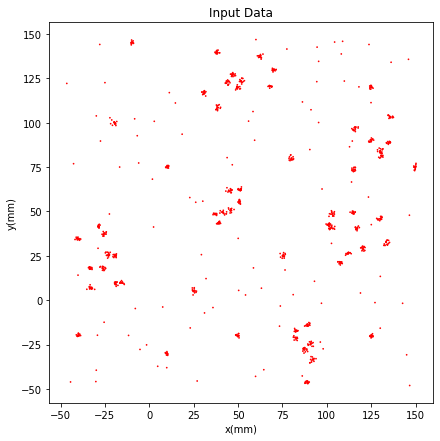

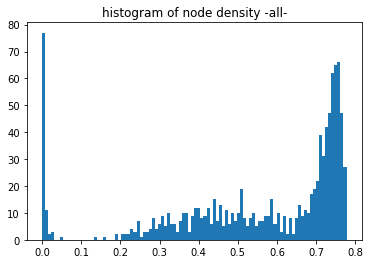

eigenvectors vecs: [[ 8.07312845e-04  2.33446563e-03  1.45366925e-02 ...  7.64264617e-17
  -3.87437025e-18  3.89203636e-16]
 [ 8.07312845e-04  2.33446563e-03  1.45366925e-02 ...  3.51079240e-16
   6.46876221e-16  1.84055871e-16]
 [ 8.07312845e-04  2.33446563e-03  1.45366925e-02 ... -4.52169173e-16
  -1.95163858e-17 -1.33074090e-16]
 ...
 [ 2.84487693e-02 -5.50401157e-03  1.21512856e-03 ... -2.52996862e-16
  -2.40032634e-16  9.56690977e-17]
 [ 8.07312844e-04  2.33446563e-03  1.45366925e-02 ... -1.32325665e-16
  -1.49849627e-16 -1.39905594e-17]
 [-2.31003969e-02 -7.32636208e-03  5.69808890e-03 ...  3.00228326e-14
   1.21667849e-17  2.91063002e-17]]
laplacian matrix:    (0, 0)	2.175894860916002
  (0, 11)	-0.7452171223517724
  (0, 13)	-0.6645719322018231
  (0, 14)	-0.747344573248793
  (0, 26)	-0.018761233113613305
  (1, 1)	3.620304486331244
  (1, 4)	-0.6330959392429946
  (1, 9)	-0.7649000979792091
  (1, 11)	-0.7753585113756416
  (1, 12)	-0.7181388895802825
  (1, 14)	-0.7288110481531166
  (

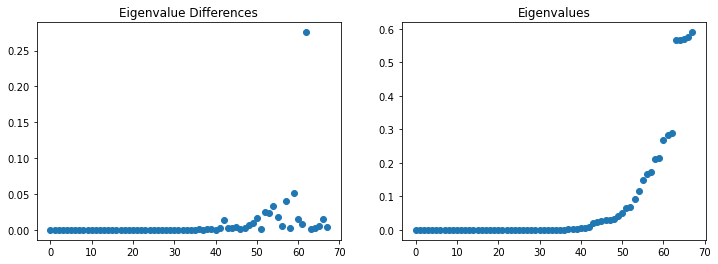

labels: output from KMeans function  [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 57 57 57 57 57 57 57 57 57
 57 57 57 57 57 57  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6 52 52 52
 52 52 52 52 52 52 52 52 52 52 52 52 47 47 47 47 47 47 47 47 47 47 47 47
 47 47 47 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10  4  4  4  4  4  4  4 53  4  4  4  4  4  4  4 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 53 53 53 53 53 53  4
 53 53 53 53 53 53 53 53  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 43
 43 43 43 43 43 43 43 43 43 43 43 43 43 43 35 35 35 35 35 35 35 35 35 35
 35 35 35 35 35 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42  9  9  

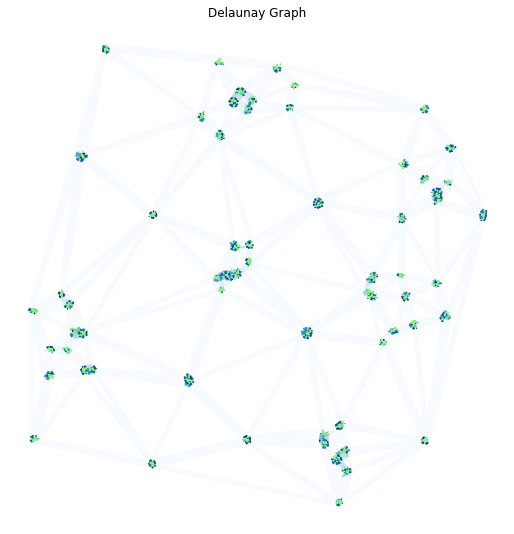

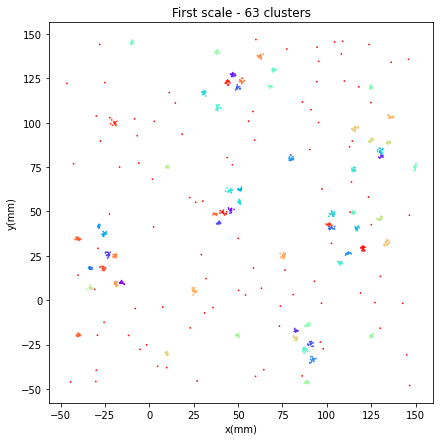

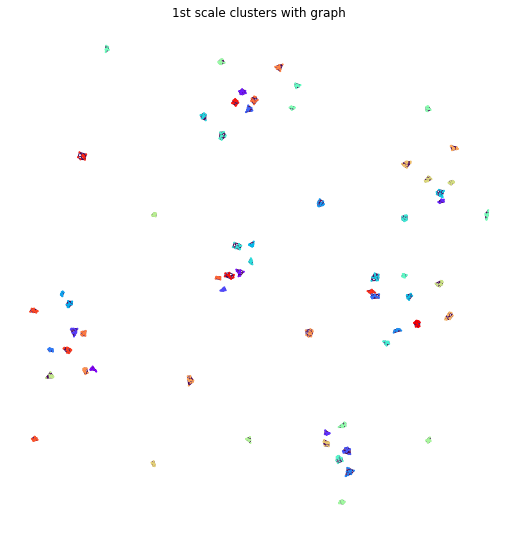

--------------------------- Second Scale ---------------------------


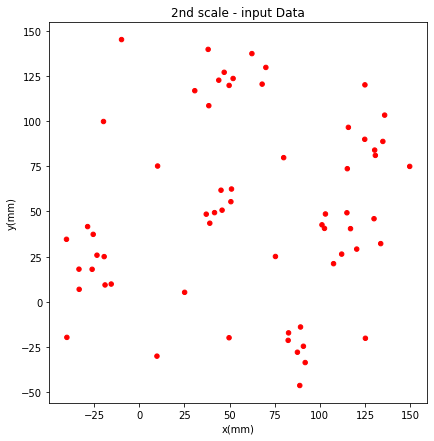

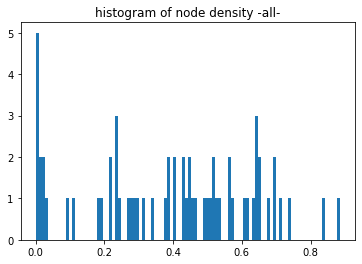

eigenvectors vecs: [[-1.40028008e-01 -7.20881037e-02 -1.26649279e-01 ...  2.30199658e-01
  -2.12632594e-05 -2.04021249e-09]
 [-1.40028008e-01 -6.35981771e-02  1.54592548e-01 ...  1.89641519e-04
  -5.27882862e-01 -2.07475182e-06]
 [-1.40028008e-01 -6.57733558e-02  2.07897377e-01 ... -4.56030920e-08
  -5.92607933e-06  5.63541828e-01]
 ...
 [-1.40028008e-01 -6.57744022e-02  2.07911181e-01 ...  6.02175801e-07
   2.76671417e-05 -4.64551874e-01]
 [-1.40028008e-01 -6.36010178e-02  1.54568488e-01 ...  1.30830767e-04
   6.88524784e-01 -2.27880011e-06]
 [-1.40028008e-01  2.83457237e-01 -6.33217083e-03 ...  5.67919097e-11
   9.87949678e-07 -2.51511534e-12]]
laplacian matrix:    (0, 0)	2.526704993918232
  (0, 12)	-0.5726341763008673
  (0, 27)	-0.504575330335983
  (0, 34)	-0.6580361752182023
  (0, 38)	-0.7914593120631793
  (1, 1)	3.353506808177354
  (1, 6)	-0.9318631177563272
  (1, 29)	-0.6047756619793246
  (1, 44)	-0.8797571520497749
  (1, 49)	-0.9371108763919269
  (2, 2)	3.2107050367289034
  (2, 

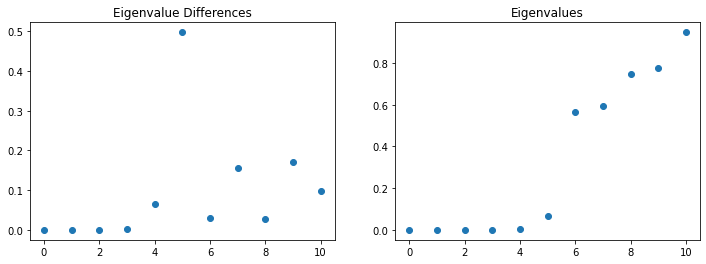

labels: output from KMeans function  [3 0 4 3 2 2 0 4 2 4 2 5 3 5 1 5 5 3 2 1 4 1 4 4 3 1 4 3 5 0 0 4 3 5 3 0 2
 2 3 1 2 3 4 1 0 2 1 5 4 0 2]


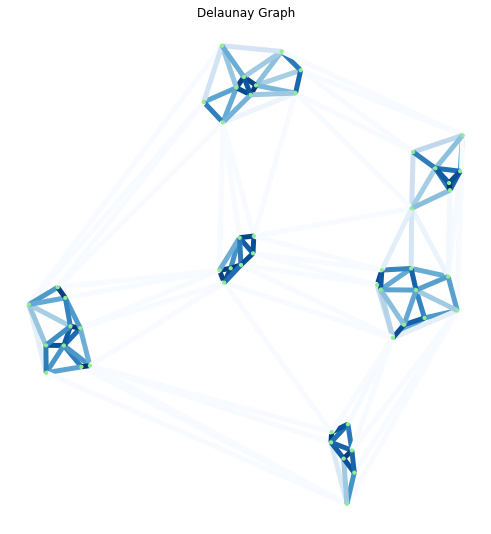

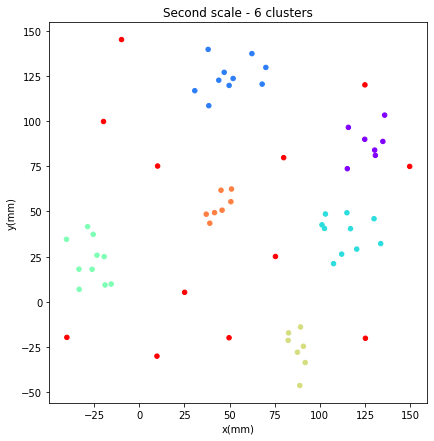

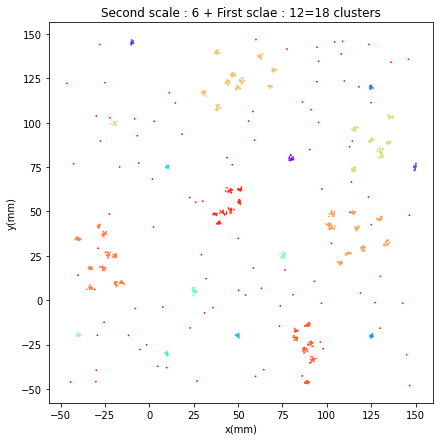

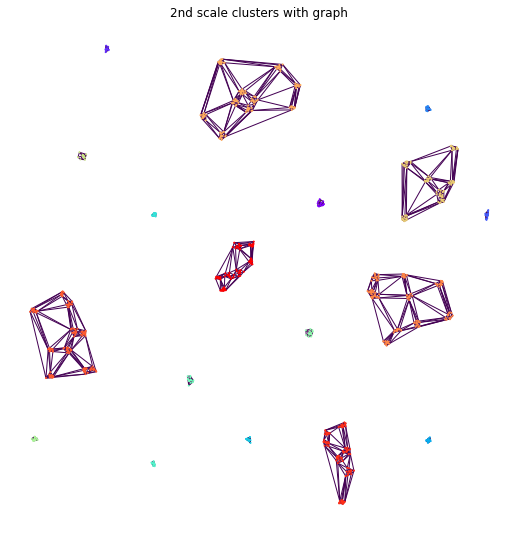

In [48]:
# read or generate data
# this data is the 2scale toy example in the papaer

def give_circle_points(rmin, rmax, n_points, center):
    # This function generates "n_points" uniform points inside a circle with center of "center", 
    # and a random radius between "r_min" and "rmax"
    r         = np.random.uniform(rmin, rmax, 1)
    r_s       = np.random.uniform(0, r, n_points)
    theta_s   = np.random.uniform(0, np.pi*2, n_points)
    sin_theta = np.sin(theta_s)
    cos_theta = np.cos(theta_s)
    points    = [[center[0] + r_s[i] * cos_theta[i], center[1] + r_s[i] * sin_theta[i]] for i in range(n_points)]  
    return points

# ------- 2nd level clusters -------
np.random.seed(29)

centers = [(-25, 25), (120, 40), (50, 125), (90, -25), (125, 90), (46, 50)]
points  = np.array([[0, 0]])
numbers = [10, 10, 10, 7, 7, 7]  

for i, center in enumerate(centers):
    if i == 5:
        np.random.seed(2)
    temp = give_circle_points(20, 24, numbers[i], center)
    for t in temp:
        points = np.append(points, [t], axis=0)

points = points[1:]  

# ------- 1st level clusters inside 2nd level clusters -------
np.random.seed(29)

centers    = points
points     = np.array([[0, 0]])
truelabels = []
k          = 0

for center in centers:
    temp       = give_circle_points(1.2, 2.4, 15, center)
    truelabels = truelabels + [k for t in list(range(15))]
    k          = k + 1
    for t in temp:
        points = np.append(points, [t], axis=0)

points=points[1:]

# ------- 1st level clusters, dispersed at 2nd scale -------
centers = [(50, -20), (125, 120), (-20, 100), (80, 80), (125, -20),
           (-40, -20), (25, 5), (10, -30), (-10, 145), (75, 25), (150, 75), (10, 75)]

for center in centers:
    temp       = give_circle_points(1.2, 2.4, 15, center)
    truelabels = truelabels + [k for t in list(range(15))]
    k          = k + 1
    for t in temp:
        points = np.append(points, [t], axis=0)
        
# ------- noise -------
noise      = np.random.uniform(low=[-50, -50], high=[150, 150], size=(100,2))
truelabels = truelabels + [k for t in  list(range(100))]
k          = k + 1
for t in noise:
    points = np.append(points, [t], axis=0)
        
P1              = points 
Sigma1          = np.ones((P1.shape[0], 2, 2)) * 0.5
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P1.shape[0], 1)).ravel()
truelabels      = np.array(truelabels)

print('--------------------------- First Scale ---------------------------')
plot_points(P1, truelabels*0, 'Input Data', 0.5)
density1, noise_points1, not_noise_points1 = denoise(P1, Sigma1, 2, 0.2, 1)
labels1, G1, k1 = cluster_single_scale(P1, Sigma1, not_noise_points1, 2, 1)
plot_the_graph(G1, P1[not_noise_points1], 'Delaunay Graph', 1)
labels1_fid     = labels1
plot_points(P1, labels1, 'First scale - ' + str(k1) + ' clusters', 0.5)
plot_clusters_with_graph(G1, P1[not_noise_points1], labels1_fid[not_noise_points1], '1st scale clusters with graph', 1)

print('--------------------------- Second Scale ---------------------------')
P2, Sigma2, n2, cluster_id2  = cluster_to_point(P1[not_noise_points1], Sigma1[not_noise_points1], 
                                   n1[not_noise_points1], k1, labels1[not_noise_points1])
plot_points(P2, n2*0, '2nd scale - input Data', 20)
density2, noise_points2, not_noise_points2 = denoise(P2, Sigma2, 13, 0.15, 1)
labels2, G2, k2 = cluster_single_scale(P2, Sigma2, not_noise_points2, 13, 1)
plot_the_graph(G2, P2[not_noise_points2], 'Delaunay Graph', 10)
labels2_fid, k21 = map_label_to_input(labels1_fid, labels2, k2, cluster_id2)
plot_points(P2, labels2, 'Second scale - ' + str(k2) + ' clusters', 20)
plot_points(P1, labels2_fid, 'Second scale : ' + str(k2) + ' + First sclae : ' + str(12) + '=' + str(k21) + ' clusters', 0.5)
plot_clusters_with_graph(G1, P1[not_noise_points1], labels2_fid[not_noise_points1], '2nd scale clusters with graph', 1)

In [ ]:
def give_circle_points(rmin, rmax, n_points, center):
    # This function generates "n_points" uniform points inside a circle with center of "center", 
    # and a random radius between "r_min" and "rmax"
    r         = np.random.uniform(rmin, rmax, 1)
    r_s       = np.random.uniform(0, r, n_points)
    theta_s   = np.random.uniform(0, np.pi*2, n_points)
    sin_theta = np.sin(theta_s)
    cos_theta = np.cos(theta_s)
    points    = [[center[0] + r_s[i] * cos_theta[i], center[1] + r_s[i] * sin_theta[i]] for i in range(n_points)]  
    return points

# ------- 2nd level clusters -------
np.random.seed(29)

centers = [(-25, 25), (120, 40), (50, 125), (90, -25), (125, 90), (46, 50)]
points  = np.array([[0, 0]])
numbers = [10, 10, 10, 7, 7, 7]  

for i, center in enumerate(centers):
    if i == 5:
        np.random.seed(2)
    temp = give_circle_points(20, 24, numbers[i], center)
    for t in temp:
        points = np.append(points, [t], axis=0)

points = points[1:]  

# ------- 1st level clusters inside 2nd level clusters -------
np.random.seed(29)

centers    = points
points     = np.array([[0, 0]])
truelabels = []
k          = 0

for center in centers:
    temp       = give_circle_points(1.2, 2.4, 15, center)
    truelabels = truelabels + [k for t in list(range(15))]
    k          = k + 1
    for t in temp:
        points = np.append(points, [t], axis=0)

points=points[1:]

# ------- 1st level clusters, dispersed at 2nd scale -------
centers = [(50, -20), (125, 120), (-20, 100), (80, 80), (125, -20),
           (-40, -20), (25, 5), (10, -30), (-10, 145), (75, 25), (150, 75), (10, 75)]

for center in centers:
    temp       = give_circle_points(1.2, 2.4, 15, center)
    truelabels = truelabels + [k for t in list(range(15))]
    k          = k + 1
    for t in temp:
        points = np.append(points, [t], axis=0)
        
# ------- noise -------
noise      = np.random.uniform(low=[-50, -50], high=[150, 150], size=(100,2))
truelabels = truelabels + [k for t in  list(range(100))]
k          = k + 1
for t in noise:
    points = np.append(points, [t], axis=0)
        
P1              = points 
Sigma1          = np.ones((P1.shape[0], 2, 2)) * 0.5
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P1.shape[0], 1)).ravel()
truelabels      = np.array(truelabels)

In [4]:
truelabels

array([ 0,  0,  0, ..., 63, 63, 63])

In [8]:
truelabels= []

k = 0
for i in range(12):
    truelabels = truelabels + [k for t in list(range(15))]
    k = k+1

In [6]:
lab = []
k = 0
lab = lab + [k for t in list(range(15))]

In [7]:
lab

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [11]:
[k for t in list(range(15))]

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]

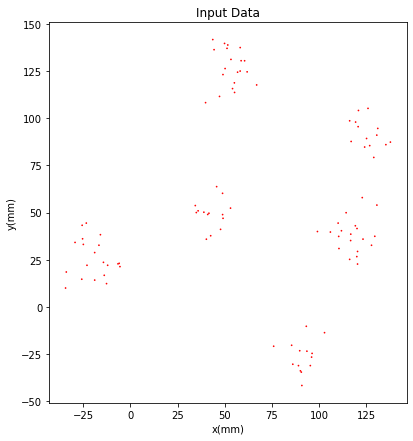

In [21]:
def give_circle_points(rmin, rmax, n_points, center):
    # This function generates "n_points" uniform points inside a circle with center of "center", 
    # and a random radius between "r_min" and "rmax"
    r         = np.random.uniform(rmin, rmax, 1)
    r_s       = np.random.uniform(0, r, n_points)
    theta_s   = np.random.uniform(0, np.pi*2, n_points)
    sin_theta = np.sin(theta_s)
    cos_theta = np.cos(theta_s)
    points    = [[center[0] + r_s[i] * cos_theta[i], center[1] + r_s[i] * sin_theta[i]] for i in range(n_points)]  
    return points

# ------- 2nd level clusters -------
np.random.seed(29)

centers = [(-25, 25), (120, 40), (50, 125), (90, -25), (125, 90), (46, 50)]
points  = np.array([[0, 0]])
numbers = [20, 20, 20, 14, 14, 14]  

k = 0 
lab = []

for i, center in enumerate(centers):
    if i == 5:
        np.random.seed(2)
    temp = give_elliptic_points(19, 25, numbers[i], center)
    for t in temp:
        points = np.append(points, [t], axis=0)

points = points[1:]  



P1 = points
plot_points(P1, [0] * 102, 'Input Data', 0.5)

In [17]:
def give_elliptic_points(rmin, rmax, n_points, center):
    # This function generates "n_points" uniform points inside a circle with center of "center", 
    # and a random radius between "r_min" and "rmax"
    r         = np.random.uniform(rmin, rmax, 1)
    r_x       = np.random.uniform(0, r, n_points)
    r_y       = np.random.uniform(0, r, n_points)
    theta_s   = np.random.uniform(0, np.pi*2, n_points)
    sin_theta = np.sin(theta_s)
    cos_theta = np.cos(theta_s)
    points    = [[center[0] + r_x[i] * cos_theta[i], center[1] + r_y[i] * sin_theta[i]] for i in range(n_points)]  
    return points

In [11]:
# ------- 1st level clusters inside 2nd level clusters -------
np.random.seed(29)

centers    = points
points     = np.array([[0, 0]])
truelabels = []
k          = 0

for center in centers:
    temp       = give_circle_points(1.2, 1.4, 15, center)
    truelabels = truelabels + [k for t in list(range(15))]
    k          = k + 1
    for t in temp:
        points = np.append(points, [t], axis=0)

points=points[1:]

array([[-26.23943811,  18.43346798],
       [-23.39606288,  25.61620227],
       [-40.09496868,  34.62366354],
       [-33.15306519,  18.19698628],
       [-25.47260543,  37.71081182],
       [-28.78806227,  41.61696967],
       [-32.96917799,   6.75324048],
       [-15.25763287,   9.84280981],
       [-18.75489609,   8.97819671],
       [-19.32419919,  25.00226439],
       [101.05129435,  42.55801436],
       [107.63737756,  21.01877843],
       [129.9459255 ,  45.74391584],
       [111.9002421 ,  26.55148419],
       [102.64102554,  40.98923053],
       [120.36872435,  28.96189084],
       [102.84183289,  48.35589314],
       [115.01124914,  49.10013944],
       [116.97243874,  40.42700451],
       [133.311969  ,  32.63115808],
       [ 30.92063947, 116.44398217],
       [ 51.74317398, 123.32897422],
       [ 70.02262526, 129.86074308],
       [ 38.2151212 , 139.31459117],
       [ 38.55023521, 108.46713284],
       [ 49.79458448, 119.98179276],
       [ 67.6763816 , 120.64224123],
 

In [ ]:
# read or generate data
# this data is the 2scale toy example in the papaer

def give_circle_points(rmin, rmax, n_points, center):
    # This function generates "n_points" uniform points inside a circle with center of "center", 
    # and a random radius between "r_min" and "rmax"
    r         = np.random.uniform(rmin, rmax, 1)
    r_s       = np.random.uniform(0, r, n_points)
    theta_s   = np.random.uniform(0, np.pi*2, n_points)
    sin_theta = np.sin(theta_s)
    cos_theta = np.cos(theta_s)
    points    = [[center[0] + r_s[i] * cos_theta[i], center[1] + r_s[i] * sin_theta[i]] for i in range(n_points)]  
    return points

# ------- 2nd level clusters -------
np.random.seed(29)

centers = [(-25, 25), (120, 40), (50, 125), (90, -25), (125, 90), (46, 50)]
points  = np.array([[0, 0]])
numbers = [10, 10, 10, 7, 7, 7]  

for i, center in enumerate(centers):
    if i == 5:
        np.random.seed(2)
    temp = give_circle_points(20, 24, numbers[i], center)
    for t in temp:
        points = np.append(points, [t], axis=0)

points = points[1:]  

# ------- 1st level clusters inside 2nd level clusters -------
np.random.seed(29)

centers    = points
points     = np.array([[0, 0]])
truelabels = []
k          = 0

for center in centers:
    temp       = give_circle_points(1.2, 2.4, 15, center)
    truelabels = truelabels + [k for t in list(range(15))]
    k          = k + 1
    for t in temp:
        points = np.append(points, [t], axis=0)

points=points[1:]

# ------- 1st level clusters, dispersed at 2nd scale -------
centers = [(50, -20), (125, 120), (-20, 100), (80, 80), (125, -20),
           (-40, -20), (25, 5), (10, -30), (-10, 145), (75, 25), (150, 75), (10, 75)]

for center in centers:
    temp       = give_circle_points(1.2, 2.4, 15, center)
    truelabels = truelabels + [k for t in list(range(15))]
    k          = k + 1
    for t in temp:
        points = np.append(points, [t], axis=0)
        
# ------- noise -------
noise      = np.random.uniform(low=[-50, -50], high=[150, 150], size=(100,2))
truelabels = truelabels + [k for t in  list(range(100))]
k          = k + 1
for t in noise:
    points = np.append(points, [t], axis=0)
        
P1              = points 
Sigma1          = np.ones((P1.shape[0], 2, 2)) * 0.5
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P1.shape[0], 1)).ravel()
truelabels      = np.array(truelabels)